In [1]:
import jax
import jax.numpy as jnp
import haiku as hk

from clu import metrics
from flax import linen as nn
from flax.training import train_state
from flax import struct, core
import optax

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import json
import numpy as np

from typing import Callable, Any, List

import torch, torchvision
from torchvision import transforms

from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import glob

import matplotlib.pyplot as plt

from dataclasses import dataclass

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
@dataclass(frozen=True)
class Config:
    train_classes: int = 50
    val_classes: int = 20
    test_classes: int = 30
    task_classes: int = 10
    T: int = 10
    steps_per_task: int = 3  # outer steps per task
    meta_batch_size: int = 4
    batch_size: int = 64
    inner_lr: float = 0.025
    outer_lr: float = 0.025
    momentum: float = 0.9
    weight_decay: float = 1e-3
    test_step: int = 20
    
    
config = Config()

In [3]:
def collate_fn(batch):
    x = jnp.asarray(torch.stack([b[0] for b in batch], dim=0).permute(0, 2, 3, 1).cpu().numpy())
    y = jnp.array([b[1] for b in batch], dtype=jnp.int32)
    return {'image': x, 'label': y}


# https://github.com/weiaicunzai/pytorch-cifar100/blob/master/conf/global_settings.py#L12
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343),
                          (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)),
    ])


np.random.seed(0)

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

len(trainset), len(testset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## Dataset construction details

1. Meta train: take original train and test to build datasets for inner and outer problems
2. Meta val: same as in meta train, but the calsses are identical in the train and validation task. Consider 3-5 tasks
3. Meta test: identical to meta val. So, we report the final results on meta test validation split.



In [4]:
np.random.seed(0)
rand_perm = np.random.permutation(100)
train_cls = rand_perm[:config.train_classes]
val_cls = rand_perm[config.train_classes: config.train_classes + config.val_classes]
test_cls = rand_perm[-config.test_classes:]

train_cls, val_cls, test_cls

(array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95, 53, 92, 78, 13,  7, 30, 22,
        24, 33,  8, 43, 62,  3, 71, 45, 48,  6, 99, 82, 76, 60, 80, 90, 68,
        51, 27, 18, 56, 63, 74,  1, 61, 42, 41,  4, 15, 17, 40, 38,  5]),
 array([91, 59,  0, 34, 28, 50, 11, 35, 23, 52, 10, 31, 66, 57, 79, 85, 32,
        84, 14, 89]),
 array([19, 29, 49, 97, 98, 69, 20, 94, 72, 77, 25, 37, 81, 46, 39, 65, 58,
        12, 88, 70, 87, 36, 21, 83,  9, 96, 67, 64, 47, 44]))

In [5]:
class DataGenerator:
    def __init__(self, trn_set, test_set):
        self.trn_cls_to_obj = {d: [] for d in range(100)}
        self.test_cls_to_obj = {d: [] for d in range(100)}
        for x, y in trn_set:
            self.trn_cls_to_obj[y].append(x)
        for x, y in test_set:
            self.test_cls_to_obj[y].append(x)

    def get_dataset(self, cls, train=True):
        cls_map = {c: i for i, c in enumerate(cls)}
        ds = []
        raw_ds = self.trn_cls_to_obj if train else self.test_cls_to_obj
        for c in cls:
            ds.extend([(x, cls_map[c]) for x in raw_ds[c]])
        return ds

    def get_dataloaders(self, cls, shuffle_val=False):
        ds = {'train': self.get_dataset(cls, True),
              'val': self.get_dataset(cls, False)}
        return {key: torch.utils.data.DataLoader(d, batch_size=config.batch_size,
                                             shuffle=True if key == 'train' or shuffle_val else False,
                                            drop_last=shuffle_val, collate_fn=collate_fn)\
            for key, d in ds.items()}


# def _get_dataset(ds, cls):
#     # scale classes to (0 ... 9)
#     cls_map = {c: i for i, c in enumerate(cls)}
#     return [(x, cls_map[y]) for x, y in ds if y in set(cls)]
    

# def get_dataloaders(trainset_orig, testset_orig, cls, shuffle_val=False):
#     ds = {'train': _get_dataset(trainset_orig, cls),
#             'val': _get_dataset(testset_orig, cls)}
#     return {key: torch.utils.data.DataLoader(d, batch_size=config.batch_size,
#                                              shuffle=True if key == 'train' or shuffle_val else False,
#                                             drop_last=shuffle_val, collate_fn=collate_fn)\
#             for key, d in ds.items()}
    
### TEST
data_gen = DataGenerator(trainset, testset)
next(iter(data_gen.get_dataloaders([0, 1])['train']))['image'].shape


(64, 32, 32, 3)

## Model

In [6]:
class CNN(hk.Module):
    def __init__(self):
        super().__init__(name="CNN")
        self.conv1 = hk.Conv2D(output_channels=16, kernel_shape=(3,3))
        self.conv2 = hk.Conv2D(output_channels=32, kernel_shape=(3,3))
        self.conv3 = hk.Conv2D(output_channels=16, kernel_shape=(3,3))
        self.flatten = hk.Flatten()
        self.linear = hk.Linear(config.task_classes)

    def __call__(self, x_batch):#, is_training=False):
        x = self.conv1(x_batch)
        # x = hk.BatchNorm(False, False, 0.9)(x, is_training)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        
        x = self.conv2(x)
        # x = hk.BatchNorm(False, False, 0.9)(x, is_training)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')

        x = self.conv3(x)
        # x = hk.BatchNorm(False, False, 0.9)(x, is_training)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        
        x = self.flatten(x)
        x = self.linear(x)
        return x


def ConvNet(x):
    cnn = CNN()
    return cnn(x)

conv_net = hk.transform(ConvNet)
rng = jax.random.PRNGKey(42)
params = conv_net.init(rng, jnp.ones((1, 32, 32, 3)))

print(conv_net.apply(params, None, np.ones((1, 32, 32, 3))).shape)
# params.keys()

(1, 10)


In [7]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')


class BiLevelTrainState(struct.PyTreeNode):
    metrics: Metrics
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    w_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    h_params: core.FrozenDict[str, Any] = struct.field(pytree_node=True)
    inner_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    inner_opt_state: optax.OptState = struct.field(pytree_node=True)
    outer_opt: optax.GradientTransformation = struct.field(pytree_node=False)
    outer_opt_state: optax.OptState = struct.field(pytree_node=True)
    lr: float  # inner lr


    @classmethod
    def create(cls, *, apply_fn, w_params, h_params, inner_opt, outer_opt, **kwargs):
        inner_opt_state = inner_opt.init(w_params)
        outer_opt_state = outer_opt.init(h_params)
        return cls(
            step=0,
            apply_fn=apply_fn,
            w_params=w_params,
            h_params=h_params,
            inner_opt=inner_opt,
            outer_opt=outer_opt,
            inner_opt_state=inner_opt_state,
            outer_opt_state=outer_opt_state,
            **kwargs,
        )

    def apply_w_gradients(self, *, w_grads, **kwargs):
        updates, new_inn_state = self.inner_opt.update(w_grads, self.inner_opt_state, self.w_params)
        new_params = optax.apply_updates(self.w_params, updates)
        return self.replace(
            step=self.step + 1,
            w_params=new_params,
            inner_opt_state=new_inn_state,
            **kwargs
        )

    def apply_h_gradients(self, *, h_grads, **kwargs):
        updates, new_out_state = self.outer_opt.update(h_grads, self.outer_opt_state, self.h_params)
        new_params = optax.apply_updates(self.h_params, updates)
        return self.replace(
            step=self.step + 1,
            h_params=new_params,
            outer_opt_state=new_out_state,
            **kwargs
        )
        

def create_bilevel_train_state(module, rng, learning_rate, outer_lr, momentum=0.9):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([1, 32, 32, 3]))
    w_params, h_params = hk.data_structures.partition(lambda m, n, p: 'linear' in m, params)
    tx_inner = optax.chain(optax.add_decayed_weights(config.weight_decay),
                           optax.sgd(learning_rate, momentum=momentum))
    tx_outer = optax.sgd(outer_lr, momentum=momentum)
    return BiLevelTrainState.create(
      apply_fn=module.apply, w_params=w_params, h_params=h_params, inner_opt=tx_inner, outer_opt=tx_outer,
      metrics=Metrics.empty(), lr=learning_rate)
    



rng = jax.random.PRNGKey(42)
state = create_bilevel_train_state(conv_net, jax.random.PRNGKey(0), 1e-3, 1e-3)
state.w_params.keys(), state.h_params.keys()
state.lr
# hk.data_structures.merge(w_params, h_params).keys()

0.001

In [8]:
@jax.jit
def loss_fn(w_params, h_params, state, batch):
    params = hk.data_structures.merge(w_params, h_params)
    logits = state.apply_fn(params, None, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss

@jax.jit
def compute_metrics(*, state, batch):
    params = hk.data_structures.merge(state.w_params, state.h_params)
    logits = state.apply_fn(params, None, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


@jax.jit
def inner_step(state: BiLevelTrainState, batch):    
    grad_fn = jax.grad(loss_fn, argnums=0)
    grads = grad_fn(state.w_params, state.h_params, state, batch)
    state = state.apply_w_gradients(w_grads=grads)
    return state


@jax.jit
def B_jvp(w_params, h_params, batch, state, v, eps=1e-7):
    """d^2 L1 / dl dw v"""
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dlam = jax.grad(loss_fn, argnums=1)
    g_plus = dl_dlam(w_plus, h_params, state, batch)
    g_minus = dl_dlam(w_minus, h_params, state, batch)
    return jax.tree_util.tree_map(lambda x, y: -state.lr * (x - y) / (2 * eps), g_plus, g_minus)


@jax.jit
def A_jvp(w_params, batch, state, v, eps=1e-7):
    w_plus = jax.tree_util.tree_map(lambda x, y: x + eps * y, w_params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - eps * y, w_params, v)
    dl_dw = jax.grad(loss_fn, argnums=0)
    g_plus = dl_dw(w_plus, state.h_params, state, batch)
    g_minus = dl_dw(w_minus, state.h_params, state, batch)
    hvp = jax.tree_util.tree_map(lambda x, y: (x - y) / (2 * eps), g_plus, g_minus)
    return jax.tree_util.tree_map(lambda x, y: x - state.lr * y, v, hvp)


@jax.jit
def fo_grad(state, val_batch):
    return jax.grad(loss_fn, argnums=1)(state.w_params, state.h_params, state, val_batch)


def drmad_grad(state, batches, val_batch):
    """T = len(batches)"""
    T = len(batches)
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    w_0 = state.w_params
    for step, batch in enumerate(batches):
        state = inner_step(state, batch)
    w_T = state.w_params
    alpha = jax.grad(loss_fn, argnums=0)(state.w_params, state.h_params, state, val_batch)
    for step, batch in enumerate(batches[::-1]):
        t = T - step
        w_tm1 = jax.tree_util.tree_map(lambda x, y: (1 - (t - 1) / T) * x + (t - 1) / T * y, w_0, w_T)
        g_so = jax.tree_util.tree_map(lambda x, y: x + y, B_jvp(w_tm1, state.h_params, batch, state, alpha), g_so)
        # update alpha
        alpha = A_jvp(w_tm1, batch, state, alpha)
    return state, g_so


def proposed_so_grad(state, batches, val_batch, gamma):
    """T = len(batches)"""
    g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    T = len(batches)
    for step, batch in enumerate(batches):
        new_state = inner_step(state, batch)
        curr_alpha = jax.grad(loss_fn, argnums=0)(new_state.w_params, state.h_params, state, val_batch)
        g_so = jax.tree_util.tree_map(lambda x, y: x * gamma ** (T - 1 - step) + y,
                                      B_jvp(state.w_params, state.h_params, batch,
                                            state, curr_alpha),
                                     g_so)
        state = new_state
    return state, g_so



In [9]:
seeds=(0,)

method = 'proposed'; gamma=0.001
# method = 'DrMAD'
# method = 'fo'

metrics_history = {seed: {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []} for seed in seeds}

data_gen = DataGenerator(trainset, testset)

for seed in seeds:
    print(f'Seed: {seed}')
    np.random.seed(seed)
    torch.manual_seed(seed)
    state = create_bilevel_train_state(conv_net, jax.random.PRNGKey(seed), config.inner_lr, config.outer_lr,
                                      config.momentum)

    cls = np.random.choice(train_cls, size=(config.task_classes,), replace=False)
    # dataloaders = get_dataloaders(trainset, testset, cls)
    dataloaders = data_gen.get_dataloaders(cls)
    meta_grad = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
    # meta train
    for outer_step in tqdm(range(500)):
        if outer_step % config.steps_per_task == 0 and outer_step > 0:
            params = conv_net.init(jax.random.PRNGKey(seed), jnp.ones([1, 32, 32, 3]))
            w_params, _ = hk.data_structures.partition(lambda m, n, p: 'linear' in m, params)
            state = state.replace(w_params=w_params)
            cls = np.random.choice(train_cls, size=(config.task_classes,), replace=False)
            # dataloaders = get_dataloaders(trainset, testset, cls)
            dataloaders = data_gen.get_dataloaders(cls)
        
        val_batch = next(iter(dataloaders['val']))
        batches = []
        for i, batch in enumerate(dataloaders['train']):
            if i >= config.T:
                break
            batches.append(batch)
        if method == 'proposed':
            state, g_so = proposed_so_grad(state, batches, val_batch, gamma)
        elif method == 'fo':
            for batch in batches:
                state = inner_step(state, batch)
                g_so = jax.tree_util.tree_map(jnp.zeros_like, state.h_params)
        elif method == 'DrMAD':
            state, g_so = drmad_grad(state, batches, val_batch)
        else:
            raise ValueError('Unknown ' + method)

        
        g_fo = fo_grad(state, val_batch)
        total_g = jax.tree_util.tree_map(lambda x, y: x + y, g_fo, g_so)
        meta_grad = jax.tree_util.tree_map(lambda x, y: x + y / config.meta_batch_size, meta_grad, total_g)
        if outer_step % config.meta_batch_size == 0 and outer_step > 0:
            state = state.apply_h_gradients(h_grads=meta_grad)
            meta_grad = jax.tree_util.tree_map(jnp.zeros_like, meta_grad)

        # eval
        if outer_step % config.steps_per_task == 0:
            for batch in dataloaders['val']:
                state = compute_metrics(state=state, batch=val_batch)
            for metric,value in state.metrics.compute().items():
                metrics_history[seed][f'test_{metric}'].append(value.item())
        
        
        
    

Seed: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:07<00:00,  1.03it/s]


array([0.18273628])

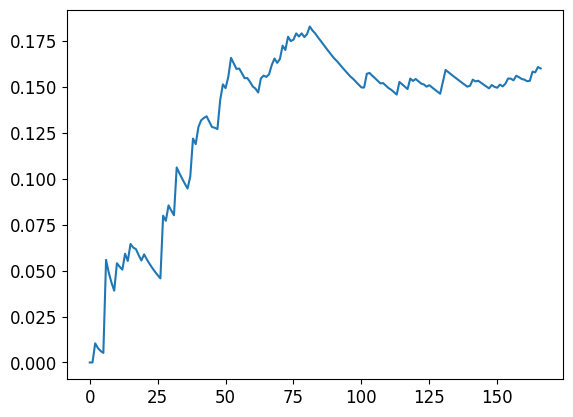

In [10]:
acc_arr = np.stack([metrics_history[s]['test_accuracy'] for s in seeds], axis=0)
plt.plot(acc_arr.mean(0))
plt.fill_between(range(acc_arr.shape[1]), acc_arr.mean(0) - acc_arr.std(0), acc_arr.mean(0) + acc_arr.std(0), alpha=0.3)


# np.save('ANIL_results/results_fo.npy', acc_arr)
np.save(f'ANIL_results/results_proposed_{gamma}.npy', acc_arr)
# np.save(f'ANIL_results/results_DrMAD.npy', acc_arr)

# ??? why no test loss???
acc_arr.max(-1)

ANIL_results/results_proposed_0.9.npy 19.7 %
ANIL_results/results_DrMAD.npy 74.5 %
ANIL_results/results_proposed_0.001.npy 18.3 %
ANIL_results/results_fo.npy 23.0 %
ANIL_results/results_proposed_0.5.npy 18.8 %


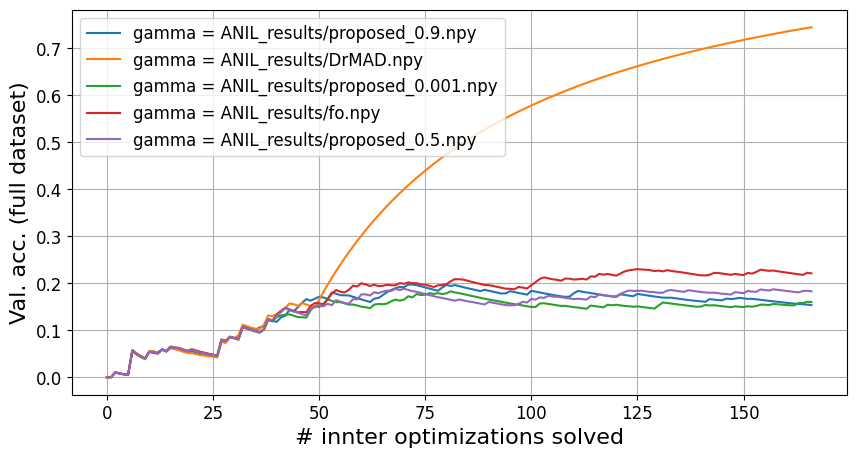

In [11]:
def get_label(desc_: str):
    desc = desc_.replace('results_', '')
    if 'drmad' in desc:
        return 'DrMAD'
    if 'IFT' in desc:
        return desc
    return f'gamma = {desc}'


plt.figure(figsize=(10, 5))
res = []
for file in glob.glob('ANIL_results/*.npy'):
    m = np.load(file)
    res.append(m.max(-1))
    print(file, round(m.max(-1).mean(), 3) * 100, '%')
    label = get_label(file)
    plt.plot(m.mean(0), label=label)
    plt.fill_between(range(m.shape[1]), m.mean(0) - m.std(0), m.mean(0) + m.std(0), alpha=0.3)    
plt.xlabel('# innter optimizations solved')
plt.ylabel('Val. acc. (full dataset)')
plt.legend()
# plt.savefig('hyper_cleaning.pdf', dpi=200, bbox_inches='tight')
plt.grid()
plt.show()
# print(ttest_ind(res[0], res[3]))